### Cryptocurrency Time Series Forecasting: Bitcoin, Ethereum and SOL-USD

1. Data Preparation

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

# Removing warnings
import warnings
warnings.filterwarnings("ignore")

# Database connection string
db_url = "XXX" # Replace 'XXX' with your actual database connection string
# Create engine
engine = create_engine(db_url)

# Query from table crypto_prices
query = "SELECT * FROM crypto.crypto_prices"

# Load data into DataFrame
df = pd.read_sql(query, engine)

In [87]:
#Filtering the 3 coins
coins = ['BTC', 'ETH', 'SOL']
df = df[df['symbol'].isin(coins)]

In [88]:
# Resampling to monthly frequency
df['Date'] = pd.to_datetime(df['Date'])
monthly = df.groupby('symbol').resample('M', on='Date').mean().reset_index()
monthly

,symbol,Date,Open,High,Low,Close,Volume
0,BTC,2020-07-31,9612.456767,9779.521181,9529.462679,9698.226510,1.840854e+10
1,BTC,2020-08-31,11639.097215,11827.761278,11453.378749,11652.394185,2.285087e+10
2,BTC,2020-09-30,10689.700163,10844.910254,10470.011263,10660.276855,3.586498e+10
3,BTC,2020-10-31,11791.307491,12018.847719,11648.076833,11886.978201,3.389918e+10
4,BTC,2020-11-30,16450.121647,16945.980208,16064.074740,16645.757422,3.643816e+10
...,...,...,...,...,...,...,...
178,SOL,2025-03-31,134.937217,140.034224,129.145773,134.183512,3.824777e+09
179,SOL,2025-04-30,130.884669,135.792216,126.776706,131.648707,3.992255e+09
180,SOL,2025-05-31,165.728702,170.127970,161.396005,166.019842,4.025053e+09
181,SOL,2025-06-30,149.335677,153.379541,145.060224,149.271263,3.674792e+09


In [89]:
print(monthly.columns)

Index(['symbol', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


2. Exploratory Data Analysis (EDA)

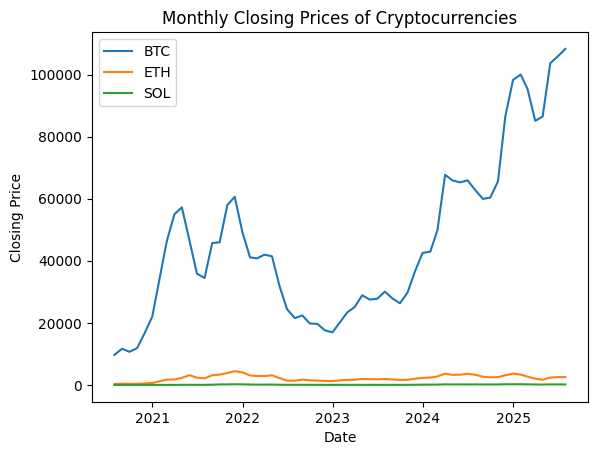

In [90]:
# Plotting of Monthly Trends
import matplotlib.pyplot as plt
import seaborn as sns   

for coin in coins:
    sns.lineplot(data=monthly[monthly['symbol'] == coin], x='Date', y='Close', label=coin)
plt.title('Monthly Closing Prices of Cryptocurrencies')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

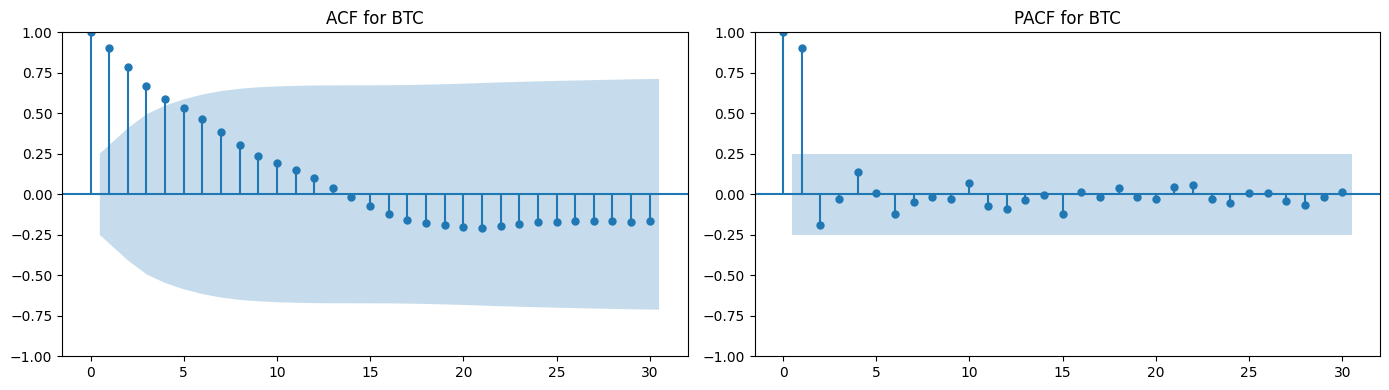

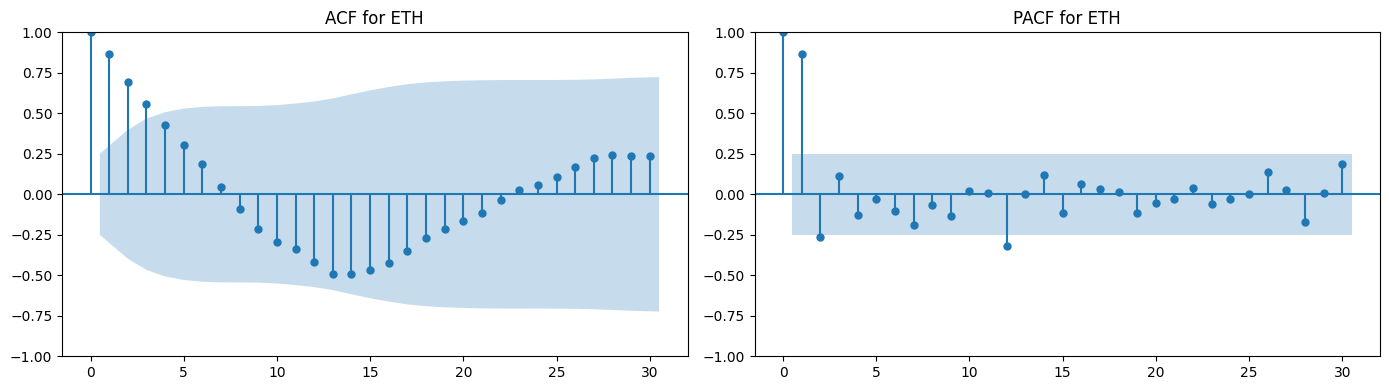

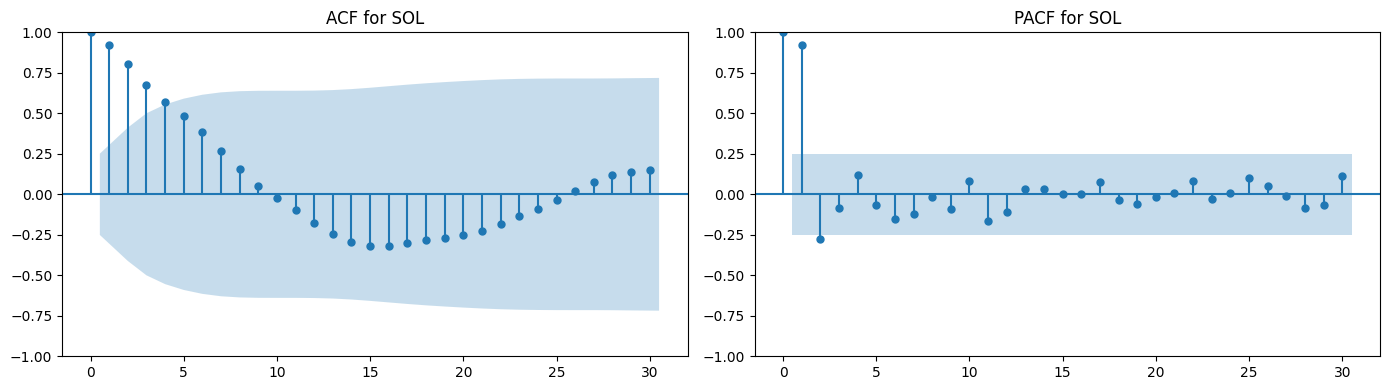

In [91]:
#Autocorrelation: Using ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

for coin in coins:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))  # 1 row, 2 columns
    coin_data = monthly[monthly['symbol'] == coin]['Close']
    plot_acf(coin_data, lags=30, ax=axes[0])
    axes[0].set_title(f'ACF for {coin}')
    plot_pacf(coin_data, lags=30, ax=axes[1])
    axes[1].set_title(f'PACF for {coin}')
    plt.tight_layout()
    plt.show()

3. Hyothesis Testing

In [92]:
# Checking for stationarity using Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Reject the null hypothesis - The series is stationary")
    else:
        print("Fail to reject the null hypothesis - The series is non-stationary(try differencing)")
for coin in coins:
    adf_test(monthly[monthly['symbol'] == coin]['Close'])

ADF Statistic: -0.41816785181093763
p-value: 0.907020918889297
Fail to reject the null hypothesis - The series is non-stationary(try differencing)
ADF Statistic: -3.6207266699489042
p-value: 0.005376919896601149
Reject the null hypothesis - The series is stationary
ADF Statistic: -1.9580609573758947
p-value: 0.3052590642115779
Fail to reject the null hypothesis - The series is non-stationary(try differencing)


In [93]:
# Differencing the series to make it stationary

from statsmodels.tsa.stattools import adfuller

# Identify non-stationary coins based on p-value >= 0.05
non_stationary_coins = []
for coin in coins:
    pval = adfuller(monthly[monthly['symbol'] == coin]['Close'])[1]
    print(f"{coin} ADF p-value: {pval}")
    if pval >= 0.05:
        non_stationary_coins.append(coin)

# Create a copy to store differenced values
monthly_diff = monthly.copy()

# Perform first-order differencing for non-stationary coins
for coin in non_stationary_coins:
    mask = monthly_diff['symbol'] == coin
    monthly_diff.loc[mask, 'Close_diff'] = monthly_diff.loc[mask, 'Close'].diff()


BTC ADF p-value: 0.907020918889297
ETH ADF p-value: 0.005376919896601149
SOL ADF p-value: 0.3052590642115779


In [94]:
# Recheck stationarity after differencing
for coin in non_stationary_coins:
    diff_series = monthly_diff.loc[monthly_diff['symbol'] == coin, 'Close_diff'].dropna()
    result = adfuller(diff_series)
    print(f"{coin} after differencing:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] <= 0.05:
        print("=> The differenced series is stationary.\n")
    else:
        print("=> The differenced series is still non-stationary.\n")

BTC after differencing:
ADF Statistic: -5.489555916574253
p-value: 2.190854959800705e-06
=> The differenced series is stationary.

SOL after differencing:
ADF Statistic: -5.603246387208629
p-value: 1.250850677954791e-06
=> The differenced series is stationary.



4. Modelling

In [95]:
# ARIMA
from pmdarima import auto_arima

btc = monthly[monthly['symbol']== 'BTC'].set_index('Date')['Close']

model = auto_arima(btc, seasonal=False, trace=True)
print(model.summary())

# Forecasting with ARIMA
forecast = model.predict(n_periods=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1222.309, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1232.092, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1222.835, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1218.659, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1233.566, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1220.575, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1220.899, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1222.168, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1218.357, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1220.123, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1220.005, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1222.092, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1220.489, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.575 seconds
                      

In [96]:
#SARIMA (Seasonal ARIMA)
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = auto_arima(btc, seasonal=True, m=12, trace=True)
print(model.summary())

forecast_sarima = model.predict(n_periods=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1226.252, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1232.092, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1224.831, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1220.658, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1233.566, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1218.659, Time=0.03 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1220.359, Time=0.27 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1222.347, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1220.575, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=1220.899, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1222.835, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1222.168, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=1218.357, Time=0.03 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=1220.323, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1

In [97]:
# Prophet
from prophet import Prophet

# Prepare data for Prophet
btc_prophet = monthly[monthly['symbol'] == 'BTC'][['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
btc_prophet['ds'] = pd.to_datetime(btc_prophet['ds'])

# Initialize and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(btc_prophet)

# Create future dates for forecasting
future = prophet_model.make_future_dataframe(periods=12, freq='M')

# Forecast using Prophet
prophet_forecast = prophet_model.predict(future)


13:13:16 - cmdstanpy - INFO - Chain [1] start processing
13:13:16 - cmdstanpy - INFO - Chain [1] done processing


In [112]:
#LSTM Neural Network
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np

#Normalizing the data
scaler = MinMaxScaler()
btc_scaled = scaler.fit_transform(btc.values.reshape(-1, 1))

#Create sequences for LSTM
X, y = [], []
for i in range(12, len(btc_scaled)):
    X.append(btc_scaled[i-12:i, 0])
    y.append(btc_scaled[i, 0])
X, y = np.array(X), np.array(y)

# Before fitting
X = X.reshape((X.shape[0], X.shape[1], 1))

#Building the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(12, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X, y, epochs=200, verbose=0)

# Forecasting with LSTM
X_input = btc_scaled[-12:].reshape((1, 12, 1))
forecast_lstm = model_lstm.predict(X_input)
forecast_lstm = scaler.inverse_transform(forecast_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


5. Model Evaluation

In [115]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error  
import pandas as pd
import numpy as np

# Evaluate the LSTM model
predictions = model_lstm.predict(X)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
actual = scaler.inverse_transform(y.reshape(-1, 1))
mae = mean_absolute_error(actual, predictions)
rmse = np.sqrt(mean_squared_error(actual, predictions))
mape = np.mean(np.abs((actual - predictions) / actual)) * 100
print(f"LSTM Model Evaluation:\nMAE: {mae}\nRMSE: {rmse}\nMAPE: {mape}%")

# Evaluate Prophet model
mae_prophet = mean_absolute_error(btc_prophet['y'], prophet_forecast['yhat'][:len(btc_prophet)])
rmse_prophet = np.sqrt(mean_squared_error(btc_prophet['y'], prophet_forecast['yhat'][:len(btc_prophet)]))
mape_prophet = mean_absolute_percentage_error(btc_prophet['y'], prophet_forecast['yhat'][:len(btc_prophet)]) * 100
print(f"Prophet Model Evaluation:\nMAE: {mae_prophet}\nRMSE: {rmse_prophet}\nMAPE: {mape_prophet}%")

# Evaluate SARIMA model
sarima_forecast = model.predict(n_periods=12)
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mae_sarima = mean_absolute_error(btc[-12:], sarima_forecast)
rmse_sarima = np.sqrt(mean_squared_error(btc[-12:], sarima_forecast))
mape_sarima = mean_absolute_percentage_error(btc[-12:], sarima_forecast) * 100
print(f"SARIMA Model Evaluation:\nMAE: {mae_sarima}\nRMSE: {rmse_sarima}\nMAPE: {mape_sarima}%")

# Evaluate ARIMA model
arima_forecast = model.predict(n_periods=12)
mae_arima = mean_absolute_error(btc[-12:], arima_forecast)
rmse_arima = np.sqrt(mean_squared_error(btc[-12:], arima_forecast))
mape_arima = mean_absolute_percentage_error(btc[-12:], arima_forecast) * 100
print(f"ARIMA Model Evaluation:\nMAE: {mae_arima}\nRMSE: {rmse_arima}\nMAPE: {mape_arima}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
LSTM Model Evaluation:
MAE: 6834.216633807701
RMSE: 8806.284030613364
MAPE: 15.32298262797633%
Prophet Model Evaluation:
MAE: 14854.730945071495
RMSE: 18058.197971187652
MAPE: 43.317695699258735%
SARIMA Model Evaluation:
MAE: 23258.207701152893
RMSE: 28626.041125540323
MAPE: 31.935848013404495%
ARIMA Model Evaluation:
MAE: 23258.207701152893
RMSE: 28626.041125540323
MAPE: 31.935848013404495%


6. Model Comparison

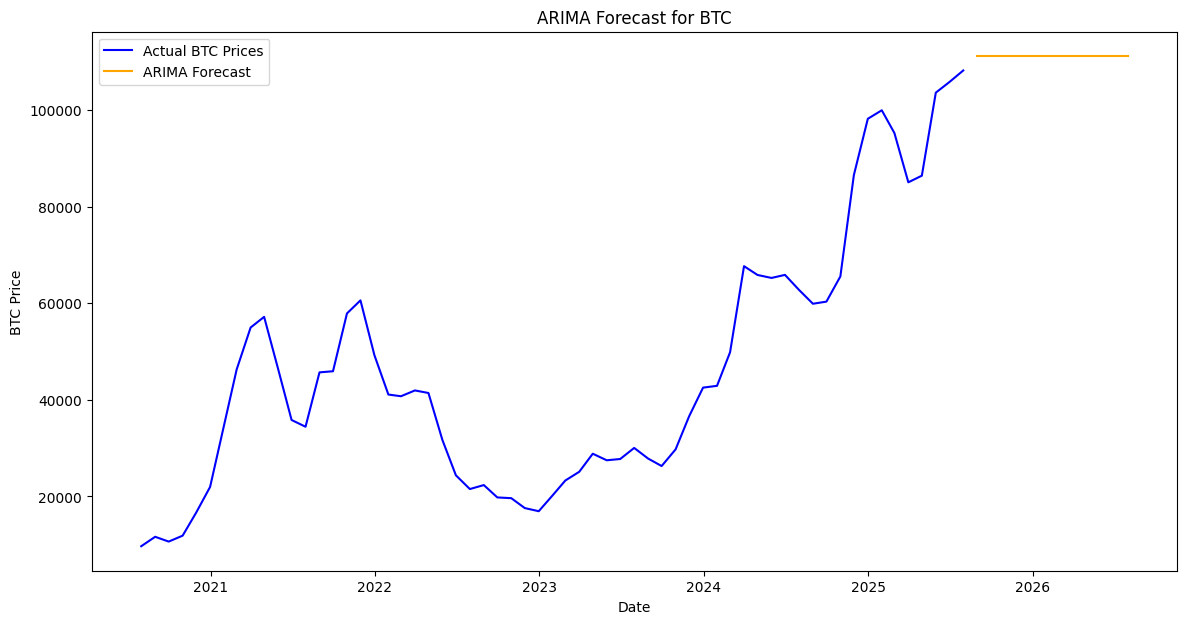

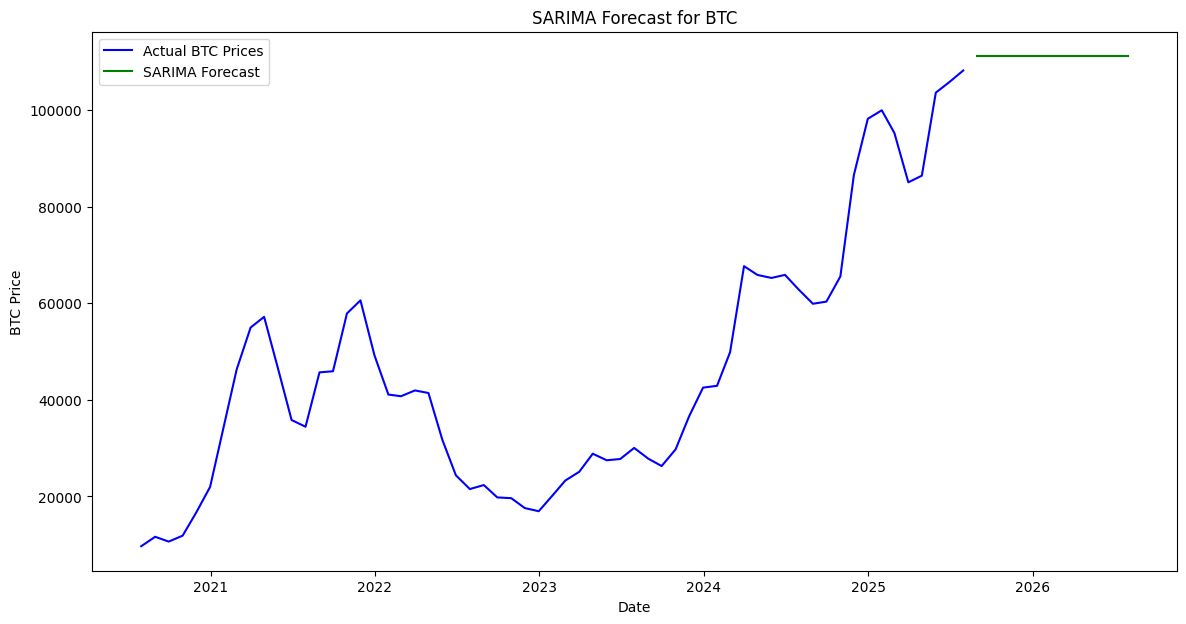

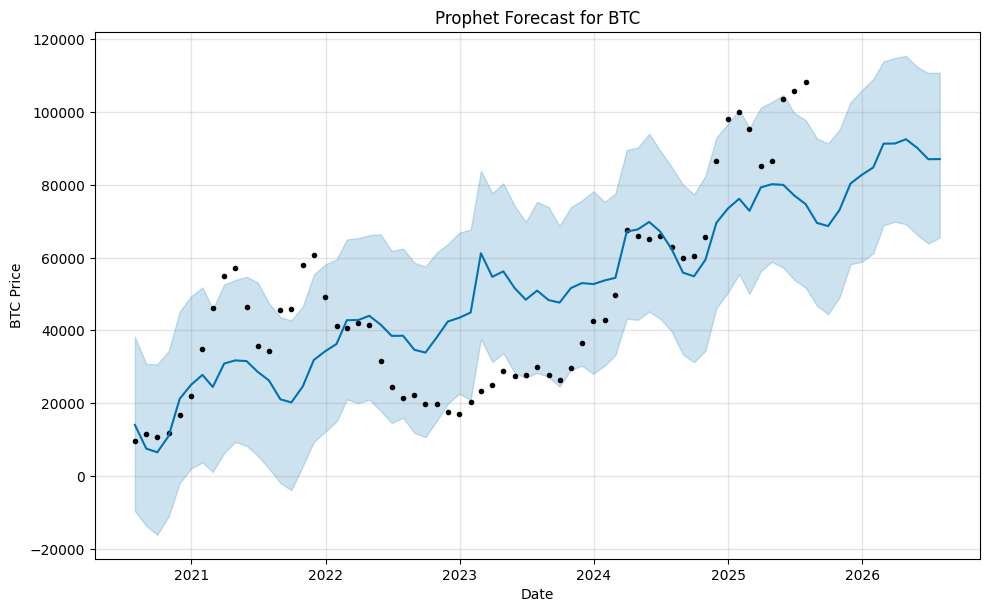

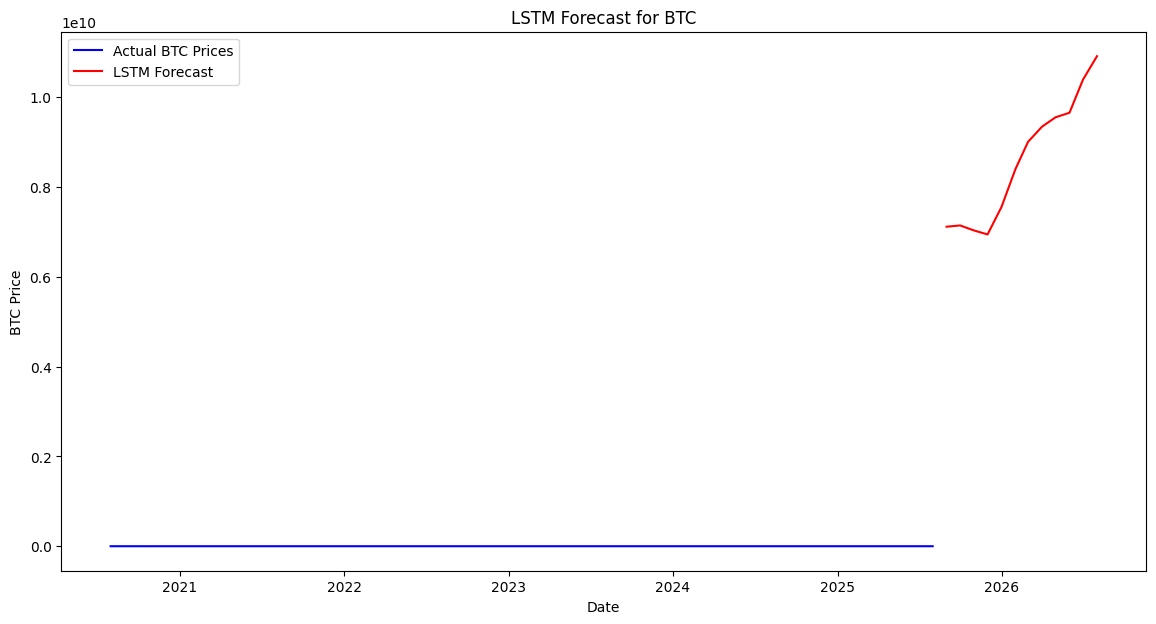

In [116]:
# Plotting Model Forecasts
import matplotlib.pyplot as plt

# Plotting ARIMA forecast
plt.figure(figsize=(14, 7))
plt.plot(btc.index, btc, label='Actual BTC Prices', color='blue')
plt.plot(pd.date_range(start=btc.index[-1], periods=13, freq='M')[1:], arima_forecast, label='ARIMA Forecast', color='orange')
plt.title('ARIMA Forecast for BTC')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend()
plt.show()

# Plotting SARIMA forecast
plt.figure(figsize=(14, 7))
plt.plot(btc.index, btc, label='Actual BTC Prices', color='blue')
plt.plot(pd.date_range(start=btc.index[-1], periods=13, freq='M')[1:], forecast_sarima, label='SARIMA Forecast', color='green')
plt.title('SARIMA Forecast for BTC')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend()
plt.show()

# Plotting Prophet forecast
import matplotlib.pyplot as plt
fig = prophet_model.plot(prophet_forecast)
plt.title('Prophet Forecast for BTC')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.show()

# Plotting LSTM forecast
plt.figure(figsize=(14, 7))
plt.plot(btc.index, btc, label='Actual BTC Prices', color='blue')
plt.plot(pd.date_range(start=btc.index[-1], periods=13, freq='M')[1:], scaler.inverse_transform(predictions[-12:]), label='LSTM Forecast', color='red')
plt.title('LSTM Forecast for BTC')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend()        
plt.show()
